## Autoencoder

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

In [49]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),]) # Converting images to tensor

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [50]:
def get_normal_digit_data(dataset, normal_digit):
    normal_images = [img for img, label in dataset if label == normal_digit]
    return normal_images

In [51]:
torch.manual_seed(42)
np.random.seed(42)
normal_digit = 3
normal_images=get_normal_digit_data(train_dataset,normal_digit)
print(len(normal_images))
print(normal_images[0].shape)

6131
torch.Size([1, 28, 28])


In [52]:
train_dataloader = DataLoader(normal_images, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [53]:
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim,input_dim,hidden_dim1,hidden_dim2):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, bottleneck_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid() # so that output is between 0 and 1
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [54]:
input_dim=28*28
hidden_dim1=128
hidden_dim2=64
bottleneck_dim=32
epochs=10
criterion = nn.MSELoss()
model = Autoencoder(bottleneck_dim,input_dim,hidden_dim1,hidden_dim2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [55]:
for epoch in range(epochs):
    total_loss = 0
    for data in train_dataloader:
        img = data
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

Epoch [1/10], Loss: 0.084898
Epoch [2/10], Loss: 0.055142
Epoch [3/10], Loss: 0.044904
Epoch [4/10], Loss: 0.038709
Epoch [5/10], Loss: 0.034473
Epoch [6/10], Loss: 0.031852
Epoch [7/10], Loss: 0.029583
Epoch [8/10], Loss: 0.027291
Epoch [9/10], Loss: 0.025191
Epoch [10/10], Loss: 0.024103


In [56]:
def calculate_reconstruction_error(model, data_loader):
    model.eval()
    reconstruction_errors = []
    true_labels = []
    
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.view(data.size(0), -1)
            output = model(data)
            
            error = torch.mean((output - data) ** 2, dim=1)
            
            reconstruction_errors.extend(error.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(reconstruction_errors), np.array(true_labels)

In [57]:
errors, labels = calculate_reconstruction_error(model, test_dataloader)
print(errors,labels)

[0.04708739 0.05178357 0.02610411 ... 0.05403574 0.06158075 0.07158308] [7 2 1 ... 4 5 6]


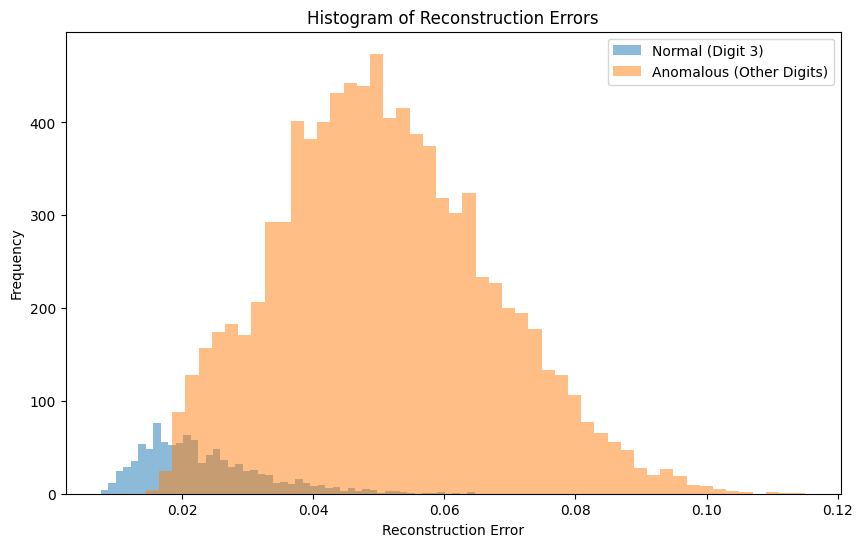

In [58]:
def plot_error_histograms(errors, labels, normal_digit):
    plt.figure(figsize=(10, 6))
    
    normal_errors = errors[labels == normal_digit]
    plt.hist(normal_errors, bins=50, alpha=0.5, label=f'Normal (Digit {normal_digit})')
    
    anomalous_errors = errors[labels != normal_digit]
    plt.hist(anomalous_errors, bins=50, alpha=0.5, label='Anomalous (Other Digits)')
    
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of Reconstruction Errors')
    plt.legend()
    plt.savefig('error_histogram.png')
    plt.show()
    plt.close()
    
    return normal_errors, anomalous_errors

normal_errors,anomalous_errors=plot_error_histograms(errors,labels,normal_digit)

In [59]:
threshold = np.percentile(normal_errors, 95) # 95% of the normal digit reconstruction errors are below this value, and only 5% are above it.
print(f"Selected threshold: {threshold:.6f}")

Selected threshold: 0.041799


In [60]:
pred_labels = (errors > threshold).astype(int)
true_binary = (labels != normal_digit).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(true_binary, pred_labels, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9919
Recall: 0.6972
F1-score: 0.8189


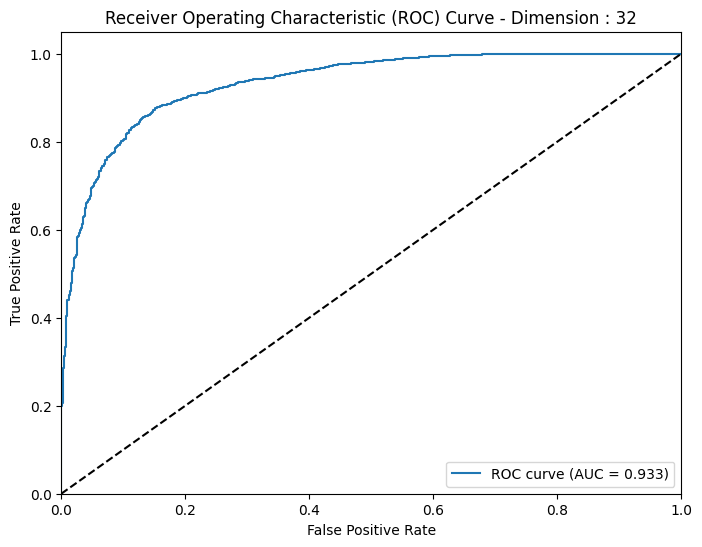

AUC-ROC: 0.9334


In [61]:
true_binary = (labels != normal_digit).astype(int)
    
fpr, tpr, _ = roc_curve(true_binary, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Dimension : 32')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()
plt.close()

print(f"AUC-ROC: {roc_auc:.4f}")

In [62]:
input_dim=28*28
hidden_dim1=128
hidden_dim2=64
bottleneck_dim=16
epochs=10
criterion = nn.MSELoss()
model = Autoencoder(bottleneck_dim,input_dim,hidden_dim1,hidden_dim2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [63]:
for epoch in range(epochs):
    total_loss = 0
    for data in train_dataloader:
        img = data
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
errors, labels = calculate_reconstruction_error(model, test_dataloader)
print(errors,labels)

Epoch [1/10], Loss: 0.086093
Epoch [2/10], Loss: 0.052945
Epoch [3/10], Loss: 0.042864
Epoch [4/10], Loss: 0.036034
Epoch [5/10], Loss: 0.033978
Epoch [6/10], Loss: 0.031220
Epoch [7/10], Loss: 0.028004
Epoch [8/10], Loss: 0.026164
Epoch [9/10], Loss: 0.024926
Epoch [10/10], Loss: 0.024031
[0.04398992 0.05105171 0.02661182 ... 0.05166065 0.05919817 0.0722478 ] [7 2 1 ... 4 5 6]


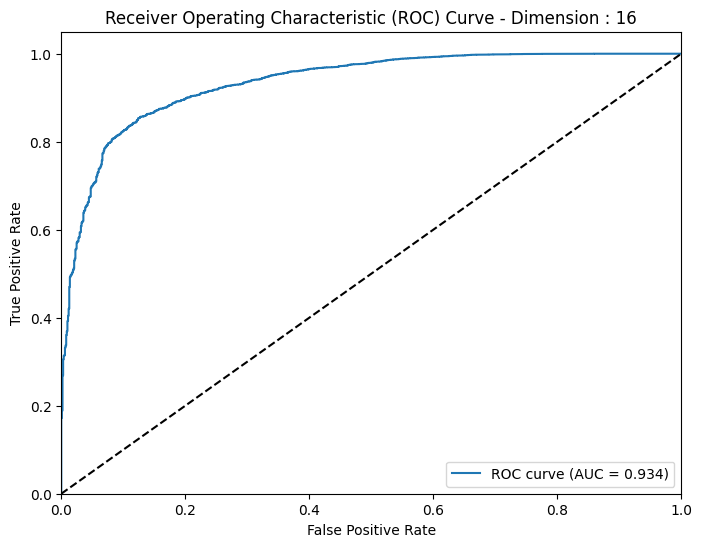

AUC-ROC: 0.9343


In [72]:
true_binary = (labels != normal_digit).astype(int)
    
fpr, tpr, _ = roc_curve(true_binary, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Dimension : 16')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()
plt.close()

print(f"AUC-ROC: {roc_auc:.4f}")

In [68]:
input_dim=28*28
hidden_dim1=128
hidden_dim2=64
bottleneck_dim=4
epochs=10
criterion = nn.MSELoss()
model = Autoencoder(bottleneck_dim,input_dim,hidden_dim1,hidden_dim2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [69]:
for epoch in range(epochs):
    total_loss = 0
    for data in train_dataloader:
        img = data
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

Epoch [1/10], Loss: 0.086882
Epoch [2/10], Loss: 0.053726
Epoch [3/10], Loss: 0.041604
Epoch [4/10], Loss: 0.034943
Epoch [5/10], Loss: 0.033433
Epoch [6/10], Loss: 0.032474
Epoch [7/10], Loss: 0.031775
Epoch [8/10], Loss: 0.031289
Epoch [9/10], Loss: 0.030927
Epoch [10/10], Loss: 0.030559


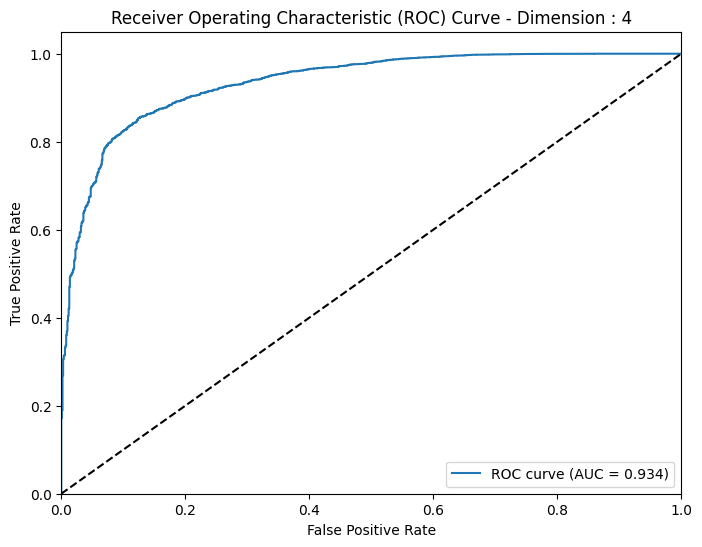

AUC-ROC: 0.9343


In [71]:
true_binary = (labels != normal_digit).astype(int)
    
fpr, tpr, _ = roc_curve(true_binary, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Dimension : 4')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()
plt.close()

print(f"AUC-ROC: {roc_auc:.4f}")

#### Observations

AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is a performance metric used to evaluate the ability of a model to distinguish between classes (typically binary classification: positive vs. negative).

1. The higher the bottleneck dimension, the more complex features the autoencoder can learn. 
2. But, it may also lead to overfitting on normal data, making it harder to distinguish anomalies. Hence, 32 dimensions as the bottleneck dimension performs lesser than 16 or 4.
2. A smaller bottleneck forces the network to learn the most essential features, which may improve anomaly detection.